# Task


# Initial Analysis:
It is clearly a typical __supervised learning__ task since we are given labeled training examples (each instance comes with the expected output, i.e., the district’s median housing price). Moreover, it is also a typical __regression task__, since you are asked to predict a value. More specifically, this is a __multiple regression__ problem since the system will use multiple features to make a prediction (it will use the district’s population, the median income, etc.). It is also a __univariate regression__ problem since we are only trying to predict a single value for each district. If we were trying to predict multiple values per district, it would be a multivariate regression problem. Finally, there is no continuous flow of data coming in the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so plain __batch learning__ should do just fine.

In [304]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit ≥0.20 is required
import sklearn 
assert sklearn.__version__ >= '0.20'

# imports
import os
import tarfile
import urllib

# Common imports
import numpy as np
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Get the Data

In [307]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        print("creating directories")
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    

In [308]:
fetch_housing_data(HOUSING_URL, HOUSING_PATH)

In [309]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [310]:
housing = load_housing_data()
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [311]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


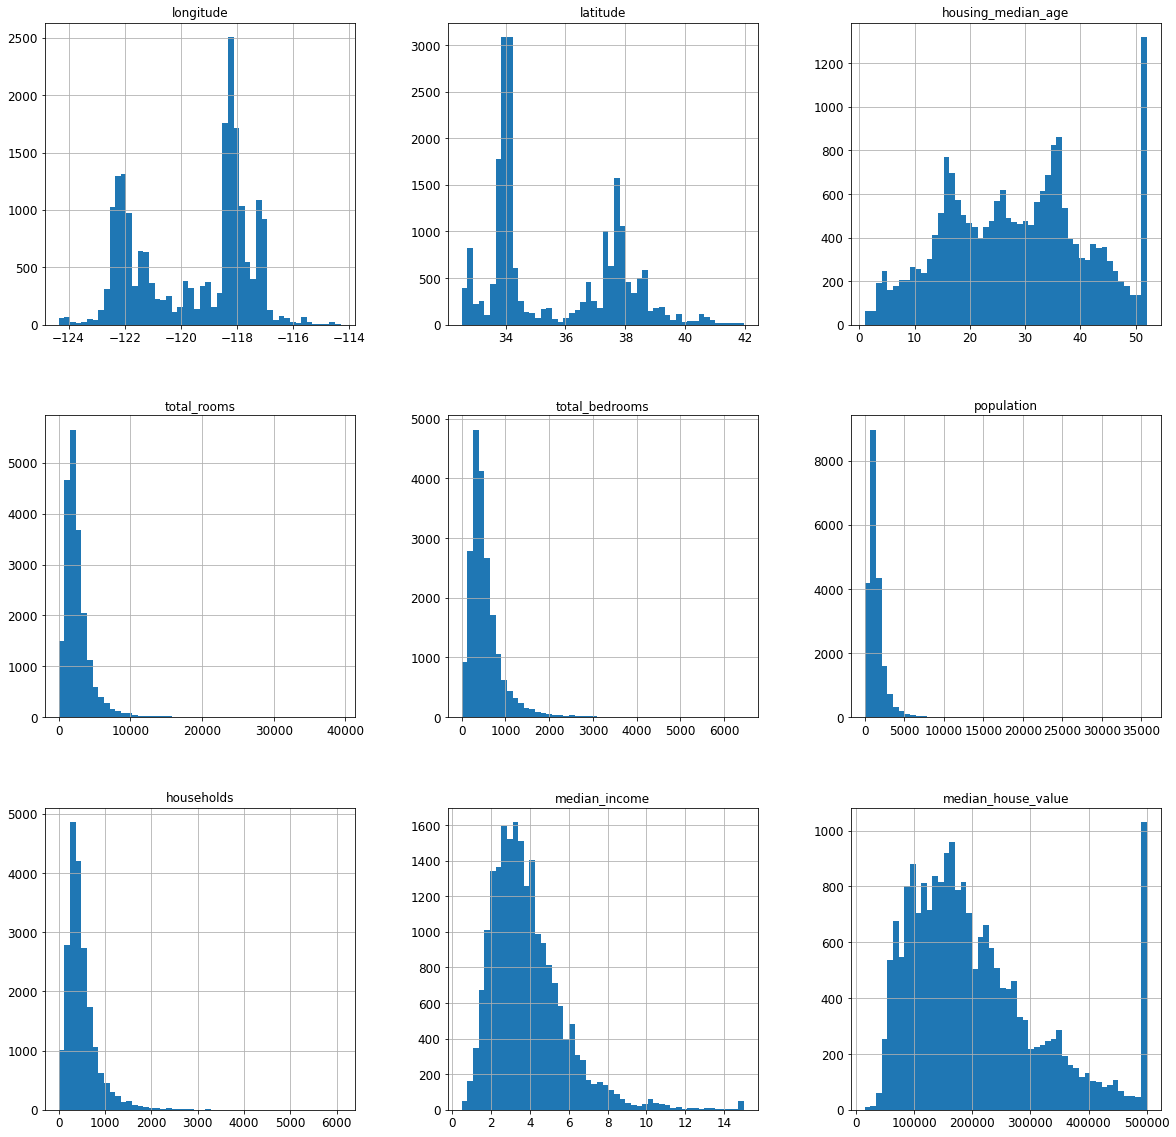

In [314]:
housing.hist(bins=50, figsize=(20,20))
plt.show()

# Histogram Observation:
1. First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes.
2. The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise predictions even beyond 500,000 dollar, then you have mainly two options:
    * Collect proper labels for the districts whose labels were capped.
    *  Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond 500,000 dollar).
3. These attributes have very different scales. We will discuss this later in this chapter when we explore feature scaling.
4. Finally, many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.


In [ ]:
# Create Test Set:
TBD until question " https://github.com/ageron/handson-ml2/issues/294"

#### Suppose you chatted with Subject Matter Experts who told you that the median income is a very important attribute to predict median housing prices. So you may want to do a strtified split based on 'median income'. But 'median income' is a continuous variable, so you may ahve to  first need to create an income category attribute. Let’s look at the median income histogram more closely : most median income values are clustered around 1.5 to 6 (i.e., \\$15,000–\\$60,000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough.

<AxesSubplot:>

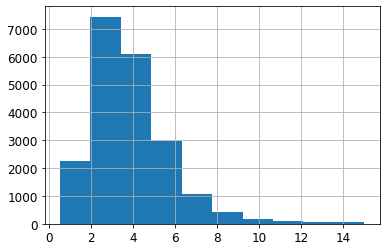

In [76]:
housing['median_income'].hist()

In [91]:
# if we let pd.cut to divide the range in 5 equal bins. This is the result. But we know that we want good balance
pd.cut(housing['median_income'], 5).value_counts()

(0.485, 3.4]    9683
(3.4, 6.3]      9088
(6.3, 9.2]      1488
(9.2, 12.1]      271
(12.1, 15.0]     110
Name: median_income, dtype: int64

In [92]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [95]:
housing["income_cat"].value_counts() # distribution is much better here.

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

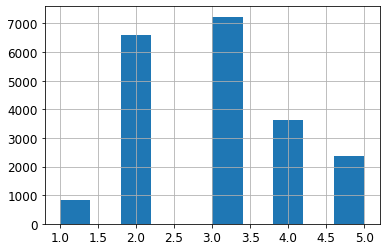

In [96]:
housing["income_cat"].hist()

In [64]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [57]:
data = datasets.load_diabetes()
data.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])

In [54]:
pd.DataFrame(data['data'], columns=data['feature_names'])

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930


In [82]:

X

array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
         0.01990842, -0.01764613],
       [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
        -0.06832974, -0.09220405],
       [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
         0.00286377, -0.02593034],
       ...,
       [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
        -0.04687948,  0.01549073],
       [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
         0.04452837, -0.02593034],
       [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
        -0.00421986,  0.00306441]])

In [91]:
X, y = datasets.load_diabetes(return_X_y=True)

X = X[:, np.newaxis, 2]
# X = X[:, 2]
print(type(X))
print(X.shape)
print(X.ndim)

<class 'numpy.ndarray'>
(442, 1)
2


In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [93]:
model = LinearRegression()
model.fit(X_train, y_train)
model.coef_

array([932.99405146])

In [94]:
preds = model.predict(X_test)
preds
model.score(X_test, y_test)

0.38880656567288396

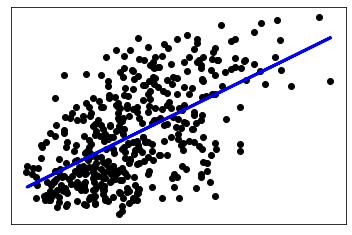

In [103]:
plt.scatter(X, y, color='black')
plt.plot(X_test, preds, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())

plt.show()

[973.27607322]
0.2704144096678375


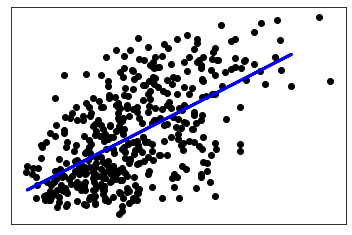

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = LinearRegression()
# print(model.coef_)
model.fit(X_train, y_train)
print(model.coef_)
y_preds = model.predict(X_test)
print(model.score(X_test, y_test))
plt.scatter(X, y, color='black')
plt.plot(X_test, y_preds, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

In [278]:

X = np.array([1,2,3,4,5,6,7,8]).T
y = np.array([5,10,15,20,25,30,35,40]).T
# X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X.shape, y.shape)
X_train = X[:-3]
print(X_train)
y_train = y[:-3]
X_test = X[-3:]
y_test = X[-3:]
model = LinearRegression()
model.fit(X_train,y_train)
print(model.coef_)
y_preds = model.predict(X_test)
print(model.score(X_test, y_test))
plt.scatter(X, y, color='black')
plt.plot(X_test, y_preds, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())
plt.show()

(8,) (8,)
[1 2 3 4 5]


ValueError: Expected 2D array, got 1D array instead:
array=[1 2 3 4 5].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [302]:
X = np.arange(10)

print(X.reshape(-1, 1))
print(X.shape)

[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]
(10,)


In [274]:
np.transpose(b).reshape(2,1)

array([[1],
       [5]])